In [32]:
from pathlib import Path
import os
import nd2
import numpy as np
import napari
import pandas as pd
from utils import plots_results_on_image, calculate_colocalization, calculate_props, extract_labels, save_bar_graph
import plotly.express as px

In [33]:
# Define the raw image path
raw_img_path = Path('./raw_data/20240703_Argolight/LM/FR_20x_dualcam.nd2')

# Construct the denoised image path using pathlib
denoised_img_path = raw_img_path.with_name(f'{raw_img_path.stem} - Denoised.nd2')

# Read raw and denoised images
raw_img = nd2.imread(raw_img_path)
denoised_img = nd2.imread(denoised_img_path)

# Read the file and extract the metadata
f = nd2.ND2File(raw_img_path)
metadata = f.metadata

# Extract and print the required metadata
for channel in metadata.channels:
    channel_meta = channel.channel
    microscope = channel.microscope
    print(f"Channel Name: {channel_meta.name}")
    print(f"Index: {channel_meta.index}")
    print(f"Emission Lambda: {channel_meta.emissionLambdaNm}")
    print(f"Excitation Lambda: {channel_meta.excitationLambdaNm}")
    print(f"Objective Name: {microscope.objectiveName}")
    print(f"Modality Flags: {', '.join(microscope.modalityFlags)}")
    print()  # Add a blank line for readability

# Print JSON info
print(f.text_info)
# Close file for garbage collection
f.close()

Channel Name: RFP
Index: 0
Emission Lambda: 592.5
Excitation Lambda: 546.0
Objective Name: S Plan Fluor LWD 20xC
Modality Flags: fluorescence, spinningDiskConfocal

Channel Name: GFP
Index: 1
Emission Lambda: 511.0
Excitation Lambda: 477.0
Objective Name: S Plan Fluor LWD 20xC
Modality Flags: fluorescence, spinningDiskConfocal

{'description': 'Camera Name: Dual Kinetix\r\nNumerical Aperture: 0.7\r\nRefractive Index: 1\r\nNumber of Picture Planes: 2\r\nPlane #1:\r\n Name: RFP\r\n Component Count: 1\r\n Relay Lens Magnification: 1x\r\n Modality: Widefield Fluorescence, Spinning Disk Confocal\r\n Camera Settings:   Binning: 1x1\r\n  Bit Depth: 12-bit\r\n  Exposure: 100 ms\r\n  Readout Speed: 100.0MHz\r\n  Multiplier: Off\r\n  Camera Mode: 12-bit (CMS)\r\n  Temperature: -0.0°C\r\n  \r\n  Conversion Gain: Sensitivity\r\n  Denoise.ai OFF\r\n  Clarify.ai OFF\r\n  Denoising: Off\r\n  Fan Speed: Medium\r\n\r\n Microscope Settings:   Microscope: Ti2 Microscope\r\n  DIC Prism, position: In\r\n  

In [35]:
# Extract labels and intensity images based on threshold values from the denoised image
ch_0, ch_1, ch_0_labels, ch_1_labels = extract_labels(denoised_img, threshold_ch0=500, threshold_ch1=200)

# Extract intensity images from raw to compare with the process of denoising
# Extract channel array
raw_ch_0 = raw_img[0,:,:]
raw_ch_1 = raw_img[1,:,:]

In [36]:
# Visualize results in Napari
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(raw_ch_0)
viewer.add_labels(ch_0_labels)
viewer.add_image(raw_ch_1)
viewer.add_labels(ch_1_labels)

<Labels layer 'ch_1_labels' at 0x23823561b50>

In [37]:
# Calculate colocalization percentage using the denoised images
percentage_positive_both = calculate_colocalization(ch_0_labels, ch_1_labels)

In [38]:
# Using labels from denoised extract mean intensities from raw images
raw_results_ch0 = calculate_props(ch_0_labels, raw_ch_0)
raw_results_ch1 = calculate_props(ch_1_labels, raw_ch_1)

# Using labels from denoised extract mean intensities from denoised images
den_results_ch0 = calculate_props(ch_0_labels, ch_0)
den_results_ch1 = calculate_props(ch_1_labels, ch_1)

In [39]:
# Create the results folder path to save all the graphs
results_folder = Path(f"./results/{denoised_img_path.stem}")
# Create the directory if it doesn't exist
os.makedirs(results_folder, exist_ok=True)

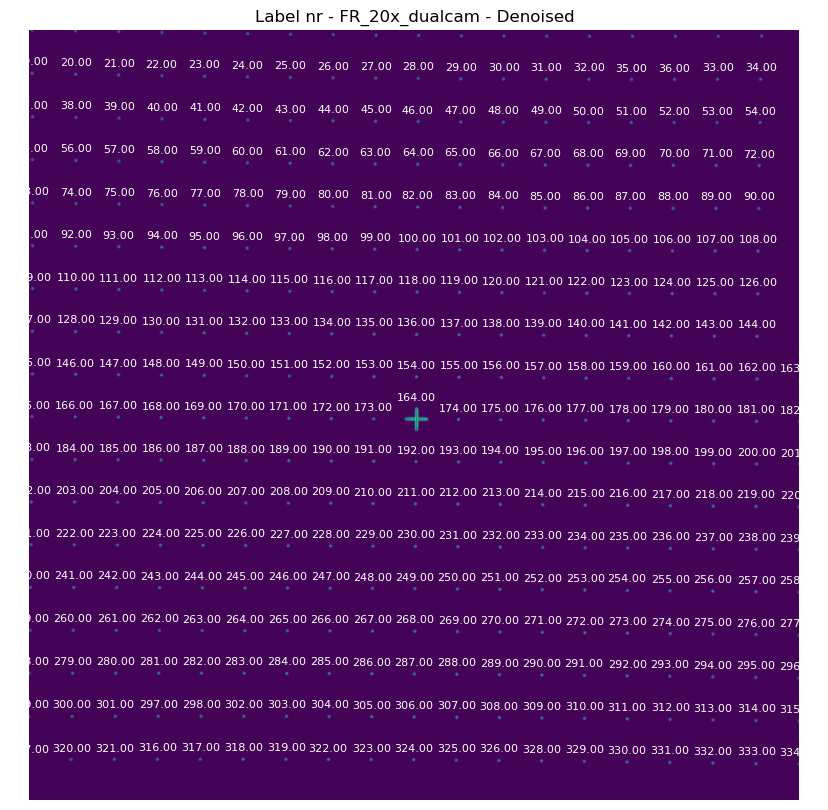

Plot saved as results\FR_20x_dualcam - Denoised\Label nr - FR_20x_dualcam - Denoised.png


In [40]:
# Assuming ch_0 and ch_1 have the same nr of labels
max_label = np.max(ch_0_labels)

# Create a 1D NumPy array starting from 1 and going up to max_label
label_nr_array = np.arange(1, max_label + 1)

plots_results_on_image(raw_ch_0, ch_0_labels, label_nr_array, title=f"Label nr - {denoised_img_path.stem}", results_folder=results_folder)

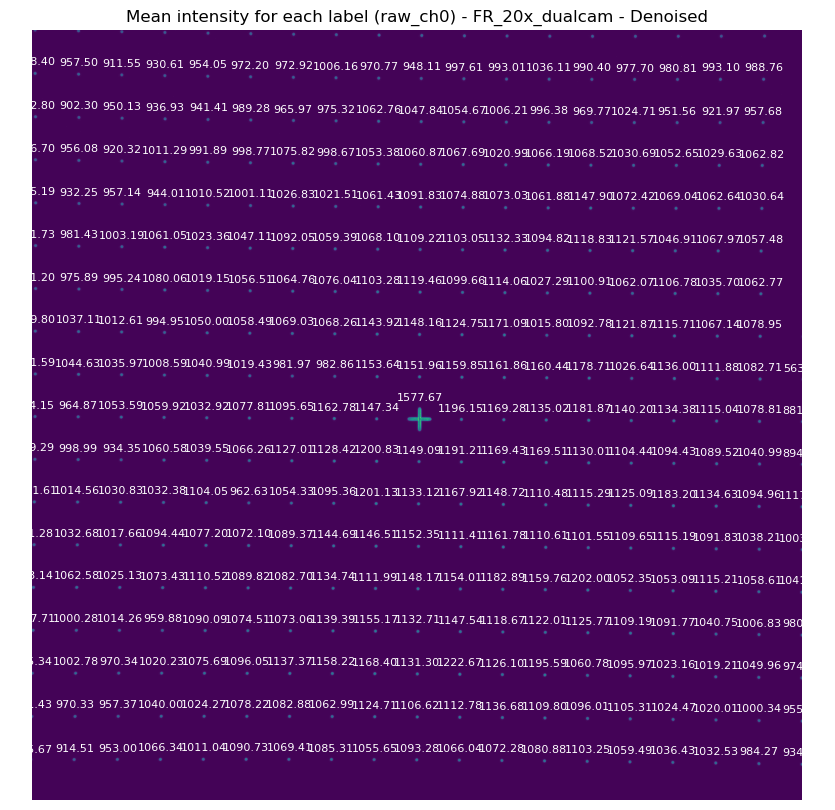

Plot saved as results\FR_20x_dualcam - Denoised\Mean intensity for each label (raw_ch0) - FR_20x_dualcam - Denoised.png


In [41]:
plots_results_on_image(raw_ch_0, ch_0_labels, raw_results_ch0['intensity_mean'], title=f"Mean intensity for each label (raw_ch0) - {denoised_img_path.stem}", results_folder=results_folder)

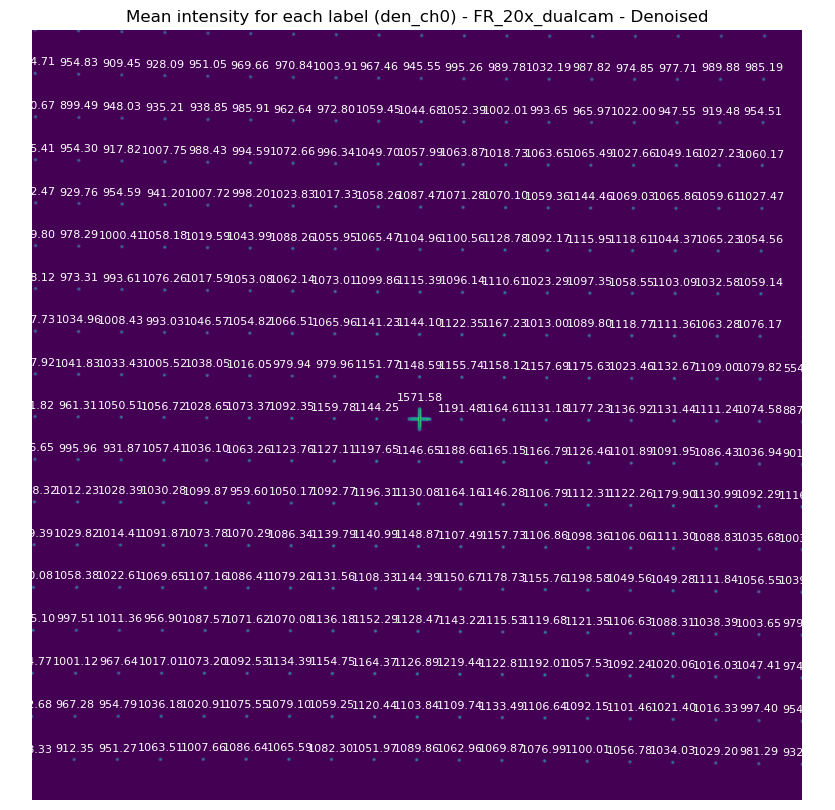

Plot saved as results\FR_20x_dualcam - Denoised\Mean intensity for each label (den_ch0) - FR_20x_dualcam - Denoised.png


In [42]:
plots_results_on_image(ch_0, ch_0_labels, den_results_ch0['intensity_mean'], title=f"Mean intensity for each label (den_ch0) - {denoised_img_path.stem}", results_folder=results_folder)

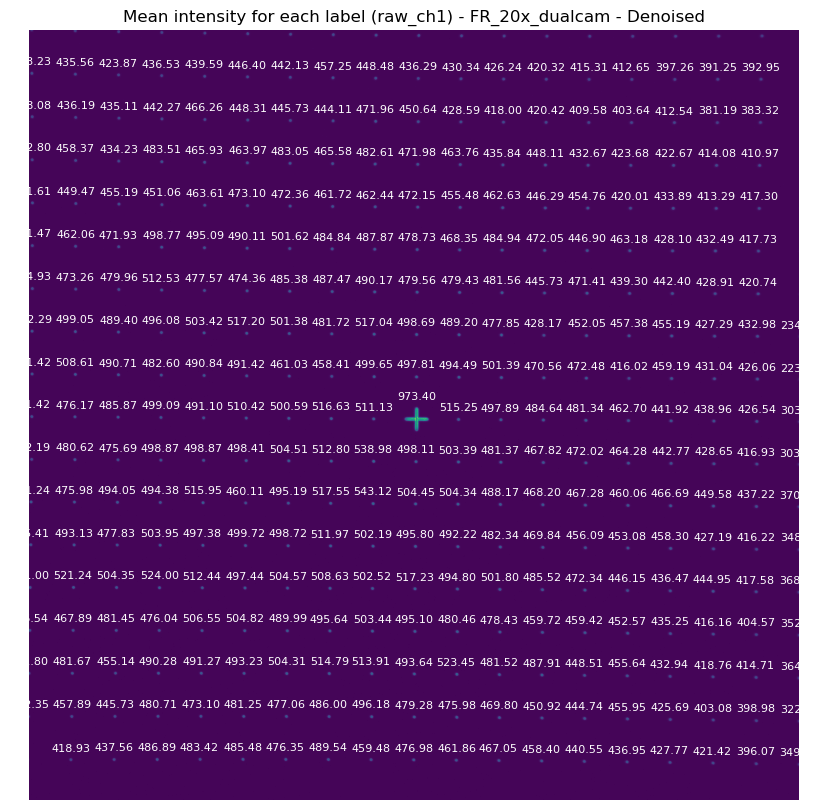

Plot saved as results\FR_20x_dualcam - Denoised\Mean intensity for each label (raw_ch1) - FR_20x_dualcam - Denoised.png


In [43]:
plots_results_on_image(raw_ch_1, ch_1_labels, raw_results_ch1['intensity_mean'], title=f"Mean intensity for each label (raw_ch1) - {denoised_img_path.stem}", results_folder=results_folder)

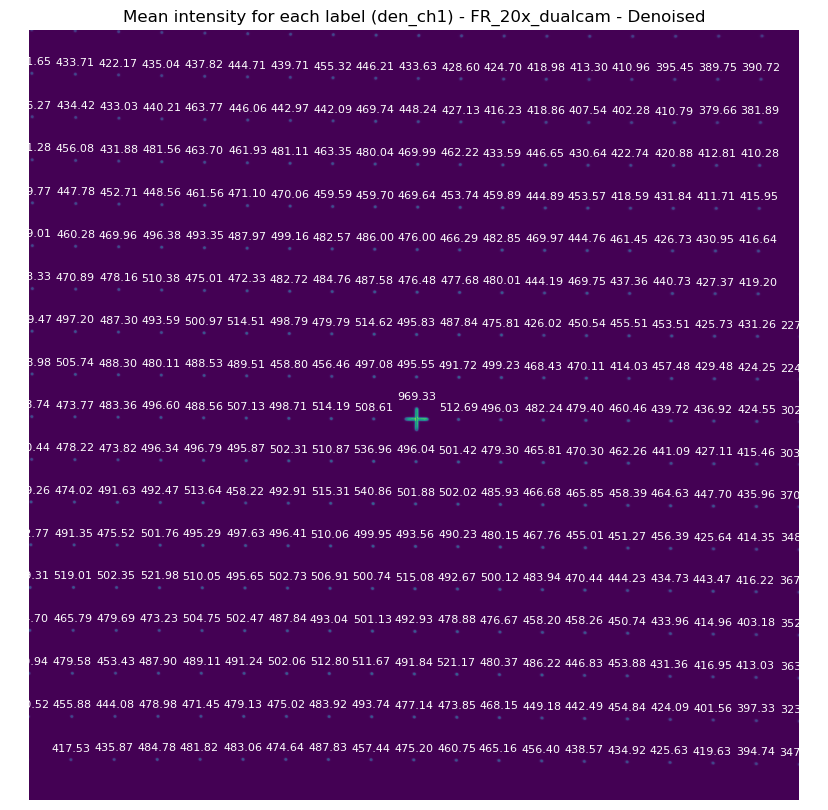

Plot saved as results\FR_20x_dualcam - Denoised\Mean intensity for each label (den_ch1) - FR_20x_dualcam - Denoised.png


In [44]:
plots_results_on_image(ch_1, ch_1_labels, den_results_ch1['intensity_mean'], title=f"Mean intensity for each label (den_ch1) - {denoised_img_path.stem}", results_folder=results_folder)

In [45]:
df_ch0 = pd.DataFrame(raw_results_ch0)
df_ch1 = pd.DataFrame(raw_results_ch1)

# Drop results from label 164 (middle cross) so it does not skew the bar graphs
df_ch0 = df_ch0[df_ch0['label'] != 164]
df_ch1 = df_ch1[df_ch1['label'] != 165]


In [46]:
# Create a bar graph using Plotly Express with hover data
fig = px.bar(df_ch0, x='label', y='intensity_mean', title=f'Bar Graph of Intensity Mean per Label (ch_0) - {denoised_img_path.stem}',
             labels={'label': 'Label', 'intensity_mean': 'Intensity Mean'},
             hover_data={'label': True, 'area': True})

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Intensity Mean',
    title={'x': 0.5},
    template='plotly_white'
)
fig.show()

# Create a bar graph using Plotly Express with hover data
fig = px.bar(df_ch1, x='label', y='intensity_mean', title=f'Bar Graph of Intensity Mean per Label (ch_1) - {denoised_img_path.stem}',
             labels={'label': 'Label', 'intensity_mean': 'Intensity Mean'},
             hover_data={'label': True, 'area': True})

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Intensity Mean',
    title={'x': 0.5},
    template='plotly_white'
)
fig.show()

In [47]:
# Save the bar graph results using matplotlib
save_bar_graph(df_ch0, 'intensity_mean', f'Bar Graph of Intensity Mean per Label (ch_0) - {denoised_img_path.stem}', results_folder)
save_bar_graph(df_ch1, 'intensity_mean', f'Bar Graph of Intensity Mean per Label (ch_1) - {denoised_img_path.stem}', results_folder)

Plot saved as results\FR_20x_dualcam - Denoised\Bar Graph of Intensity Mean per Label (ch_0) - FR_20x_dualcam - Denoised.png
Plot saved as results\FR_20x_dualcam - Denoised\Bar Graph of Intensity Mean per Label (ch_1) - FR_20x_dualcam - Denoised.png
